In [948]:
import math
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [949]:
print(tf.__version__)

2.10.0


In [950]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [951]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame, feat = None):
    if feat is None:
        count_vectorizer = CountVectorizer(binary=True)
    else:
        count_vectorizer = CountVectorizer(binary=True, vocabulary=feat)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [952]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [953]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .75)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.90)

In [954]:
def createDf(data):
    pd_df = pd.DataFrame(data)
    return pd_df
def addColumn(copy_to, copy_from ,cname):
    copy_to[cname] = copy_from[cname]
    return copy_to

In [955]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']

In [956]:
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']

In [957]:
active_train_df = createDf(active_train)
active_binding_train_df =  createDf(active_binding_train)
active_train_df = addColumn(active_train_df, active_binding_train_df, 'binding')

In [958]:
not_active_train_df = createDf(not_active_train)
not_active_binding_train_df =  createDf(not_active_binding_train)
not_active_train_df = addColumn(not_active_train_df, not_active_binding_train_df, 'binding')

In [959]:
train_df = pd.concat([active_train_df,not_active_train_df]).reset_index()
train_df = train_df.drop('index',axis=1)
print(train_df.binding.value_counts())

0    649
1     58
Name: binding, dtype: int64


In [960]:
test_df = pd.concat([active_test_df,not_active_test_df]).reset_index()
test_df = test_df.drop('index',axis=1)
print(test_df.binding.value_counts())

0    73
1    20
Name: binding, dtype: int64


In [966]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler()
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1,1),train_df.binding)

In [967]:
final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

1    649
0    649
Name: binding, dtype: int64
0    73
1    20
Name: binding, dtype: int64


In [968]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [969]:
print(training_split.shape)
print(test_split.shape)

(1298, 82250)
(93, 82250)


In [970]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)
features = select_k_best_features(training_split,train_result,.70,vectorizer_best.get_feature_names_out())
features

array(['1000', '10000', '100000', ..., '99997', '99998', '99999'],
      dtype=object)

In [971]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence,features)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [972]:
training_split.shape

(1298, 57574)

In [973]:
initial_weight = np.ones(training_split.shape[0])*(1/training_split.shape[0])

In [974]:
def updateWeight(missmatch, weight, alpha):
    mi = 0
    missmatch_size = len(missmatch)
    wi = 0

    new_weight = []
    norm_constant = 0
    while wi < len(weight):
        if mi < missmatch_size and missmatch[mi] == wi:
            k = weight[wi] * math.exp(alpha)
            mi+=1
        else:
            k = weight[wi] * math.exp(-1*alpha)
        new_weight.append( k )
        norm_constant += k
        wi += 1

    new_weight /= norm_constant
    sum =0
    for i in new_weight:
        sum+=i
    print(sum)
    # plt.plot(new_weight)
    # plt.show()
    return new_weight

In [975]:
from sklearn.metrics import f1_score, accuracy_score
def findMissClassificatonIndex(predicted, test_res, weight):
    error_rate = 0
    missmatch_indexes = []
    incorrect= []
    print(f1_score(test_res, predicted))
    print(accuracy_score(test_res, predicted))
    for i, (pred, real) in enumerate(zip(predicted, test_res)):
        if pred != real:
            incorrect.append((i, pred, real))
            missmatch_indexes.append(i)
            error_rate += weight[i]
    error_rate /= len(predicted)
    # print(incorrect)
    return error_rate, missmatch_indexes

In [976]:
def rejectionSampling(train_data, train_res, weights):
    samplesize  = int(3 * len(train_data))
    new_train_data = []
    new_train_res = []
    new_weights = []
    adding_index =[]
    max_w = max(weights)

    for i in range(samplesize):
        while True:
            index = random.randrange(len(weights))
            u = max_w * random.random()
            if u <= weights[index]:
                new_train_data.append(train_data[index])
                new_train_res.append(train_res[index])
                adding_index.append(index)
                break
    # print(adding_index)
    return new_train_data, new_train_res

In [986]:
from sklearn.tree import DecisionTreeClassifier

ensemble_size = 50
ensemble = []
alphas = []
def boosting(weights):

    for i in range(ensemble_size):
        train_data, train_res = rejectionSampling(training_split, train_result, weights)
        # print(sum(train_res))
        tree = DecisionTreeClassifier(max_depth= 8)
        tree.fit(train_data, train_res)
        print(sum(train_res))
        predicted_result = tree.predict(training_split)

        error_rate, error_indexes = findMissClassificatonIndex(predicted_result, train_result, weights)
        print("error_rate:", error_rate)

        if error_rate > .5:
            weights = np.ones(training_split.shape[0]) * (1/training_split.shape[0])
            print("re-balancing and training because error:", error_rate)
            continue

        amount_of_say = 0.5 * ( math.log( (1-error_rate) / error_rate ) )
        alphas.append(amount_of_say)
        ensemble.append(tree)
        weights = updateWeight(error_indexes, weights, amount_of_say)
        # Rejection Sampling0
        # plt.plot(weights)
        # plt.show()

1966
0.9820452771272444
0.9822804314329738
error_rate: 1.3651439573980124e-05
1.000000000000004
3407
0.3154285714285714
0.5385208012326657
error_rate: 2.7370336380721334e-07
1.0000000000000158
3290
0.5938407902382337
0.46147919876733434
error_rate: 5.928735508439442e-07
0.9999999999999928
3362
0.6842382709541381
0.5385208012326657
error_rate: 3.1460160891486544e-07
0.9999999999999807
9
0.10510948905109489
0.5277349768875192
error_rate: 4.184993954163666e-10
1.0000000000000007
3891
0.6813648293963255
0.5323574730354391
error_rate: 5.528261796378373e-07
1.0000000000000289
2
0.0967741935483871
0.5254237288135594
error_rate: 5.570366874201455e-07
0.9999999999999984
3891
0.6749869994799792
0.5184899845916795
error_rate: 5.703391416998749e-07
0.9999999999999611
1
0.08541973490427097
0.5215716486902927
error_rate: 5.593531352939741e-07
1.000000000000003
3891
0.6774530271398747
0.5238828967642527
error_rate: 5.706044704919305e-07
0.9999999999999892
3
0.13486370157819225
0.5354391371340523
erro

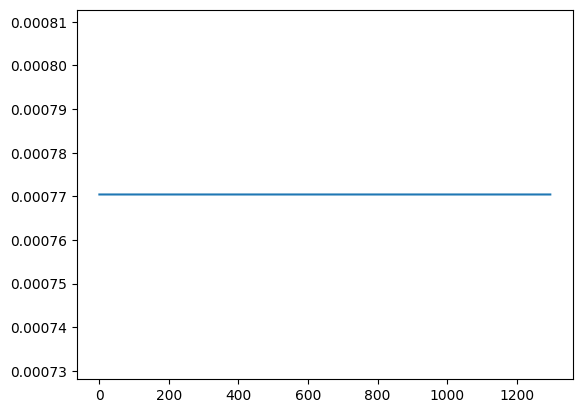

In [987]:
plt.plot(initial_weight)
boosting(initial_weight)


In [989]:
alphas

[5.600825963533082,
 7.555610328573448,
 7.169142052081957,
 7.48597920878662,
 10.797172835112924,
 7.204110827271491,
 7.2003170880234855,
 7.1885170486368954,
 7.198242138535281,
 7.188284496435923,
 7.220041415505361,
 7.179920179288914,
 7.176208918619349,
 7.248002583476407,
 7.21250344735555,
 7.203085611380743,
 7.196413267468851,
 7.177030353884601,
 7.28084464107347,
 7.206481040814026,
 7.258866146157727,
 7.23089825036921,
 7.1284789333966,
 7.239906198335495,
 7.1693488709839635,
 7.199945606408587,
 7.209545929920742,
 7.188531103227802,
 7.196235160843368,
 7.16934886048863,
 7.288981281616928,
 7.1757253020841585,
 7.311522059512006,
 7.174510566825865,
 7.361510856631295,
 7.167999521310951,
 7.19753663721198,
 7.185056887424472,
 7.240325131221216,
 7.187473685182896,
 7.183869408247169,
 7.185611486779912,
 7.553882097292855,
 7.223764841604482,
 7.053947652420583,
 7.128821361465241,
 7.358495403649034,
 7.221281477095878,
 7.309996982375797,
 7.1715238770484255]

In [1002]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
f1=[]

def repeat(test_split, test_result, start, end):
    mx = 0
    size = 0
    data = []
    for i in range(start,end):
        data = some_pred(test_split, i)
    #     tn, fp, fn, tp = confusion_matrix(test_result, data).ravel()
    #     precision = tp / (tp+ fp)
    #     recall = tp / (tp+ fn)
    #     score = (2 * precision * recall) / (precision + recall)
    #     print(score)
    #     f1.append(score)
    #     if mx < score:
    #         mx = score
    #         size = i
    #     # print(i)
    # print(mx,size)
    return data

def some_pred(test_split, esize):
    data = []
    for j in range(len(test_split)):
        pa=0
        na =0
        for i in range(esize):
            k = ensemble[i].predict([test_split[j]])
            if k[0] == 1:
                pa += alphas[i]
            else:
                na+=alphas[i]
        if pa >=na:
            data.append(1)
        else:
            data.append(0)
    # f1.append(f1_score(test_result, data, average="macro"))
    # acc.append(accuracy_score(test_result, data))
    return data

0.35398230088495575
0.8205128205128205
0.12903225806451613
0.8205128205128205
0.8205128205128205 1


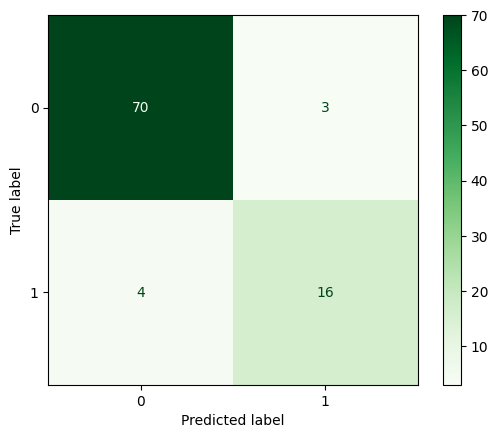

In [1000]:
ConfusionMatrixDisplay.from_predictions(test_result,repeat(test_split, test_result, 0, 4),cmap='Greens')

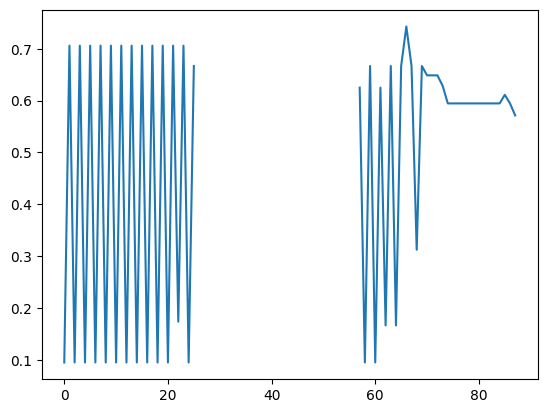

In [981]:
plt.plot(f1)

In [894]:
repeat(test_split,107,108)

107


[1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

ValueError: x and y must have same first dimension, but have shapes (180,) and (1,)

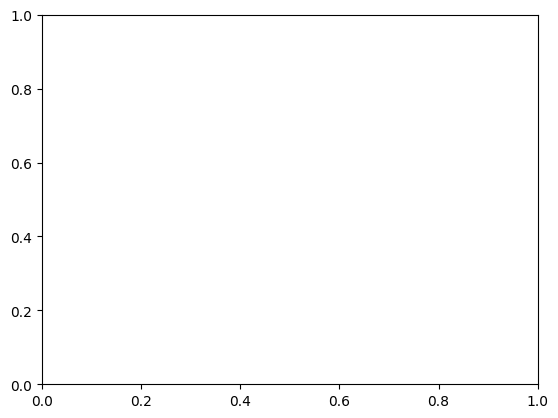

In [883]:
plt.plot(range(20,200),f1)

In [1007]:
table_test = pd.read_table('./1663769555_8653905_test.txt', names=['sequence'])
unlabeled_test = vectorizer_best.transform(table_test.sequence).toarray()

predicted_data = repeat(unlabeled_test, None,0, 4)

In [1008]:
print(len(predicted_data))
print(unlabeled_test.shape)

350
(350, 57574)


In [1009]:

import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], predicted_data))
outfile.close()